# **LAB 1 Arabic alphabets**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import tensorflow as tf
from keras.utils import to_categorical
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
!wget http://upscfever.com/datasets/csvTrainImages13440x1024.csv -P drive/app
!wget http://upscfever.com/datasets/csvTrainLabel13440x1.csv -P drive/app
!wget http://upscfever.com/datasets/csvTestImages3360x1024.csv -P drive/app
!wget http://upscfever.com/datasets/csvTestLabel3360x1.csv -P drive/app

--2020-12-06 20:08:47--  http://upscfever.com/datasets/csvTrainImages13440x1024.csv
Resolving upscfever.com (upscfever.com)... 172.67.193.2, 104.27.176.133, 104.27.177.133, ...
Connecting to upscfever.com (upscfever.com)|172.67.193.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://upscfever.com/datasets/csvTrainImages13440x1024.csv [following]
--2020-12-06 20:08:48--  https://upscfever.com/datasets/csvTrainImages13440x1024.csv
Connecting to upscfever.com (upscfever.com)|172.67.193.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘drive/app/csvTrainImages13440x1024.csv’

csvTrainImages13440     [  <=>               ]  28.22M   102MB/s    in 0.3s    

2020-12-06 20:08:48 (102 MB/s) - ‘drive/app/csvTrainImages13440x1024.csv’ saved [29593405]

--2020-12-06 20:08:48--  http://upscfever.com/datasets/csvTrainLabel13440x1.csv
Resolving upscfever.com (upscfever.com)... 172.67.193.2, 10

In [3]:
train_data = pd.read_csv('drive/app/csvTrainImages13440x1024.csv', header = None)
train_label = pd.read_csv('drive/app/csvTrainLabel13440x1.csv', header = None)
test_data = pd.read_csv('drive/app/csvTestImages3360x1024.csv', header = None)
test_label = pd.read_csv('drive/app/csvTestLabel3360x1.csv', header = None)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB


Data Preprocessing

In [5]:
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1
test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

In [6]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(13440, 1024)
(13440, 1)
(3360, 1024)
(3360, 1)


In [7]:
train_data = train_data.reshape(-1,32,32,1)
test_data = test_data.reshape(-1,32,32,1)

In [8]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [9]:
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

In [10]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

Augmenting Images

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        validation_split=0.2)  # randomly flip images

In [12]:
train_generator = datagen.flow(x=train_data,y=train_label,subset='training',seed=42,batch_size=50) # set as training data
validation_generator = datagen.flow(x=train_data,y=train_label,subset='validation',seed=42,batch_size=50)

Building CNN

In [13]:
cnn = Sequential()
cnn.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (32,32,1)))
cnn.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
cnn.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
cnn.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
cnn.add(Dense(units = 256, activation = "relu"))
cnn.add(Dropout(0.25))
cnn.add(Dense(28, activation = "softmax"))

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [15]:
cnn.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Fitting data to CNN

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="best.hdf5",save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.003,patience=15,mode='max',restore_best_weights=True)

In [17]:
history=cnn.fit(train_generator,validation_data = validation_generator,epochs=25,verbose=0,steps_per_epoch = train_data.shape[0]*0.8//50,validation_steps = train_data.shape[0]*0.2//50 ,callbacks=[model_checkpoint_callback, TqdmCallback(verbose=1),es])

In [18]:
dev_acc=cnn.evaluate(test_data,test_label)

105/105 [==============================] - 0s 3ms/step - loss: 0.1683 - accuracy: 0.9655


Training Loss vs Validation Loss

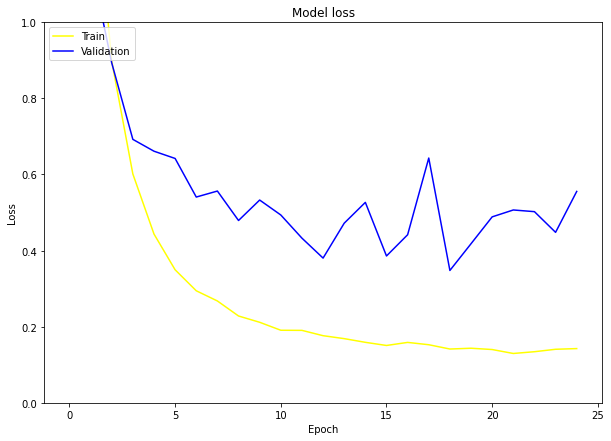

In [19]:
plt.figure(figsize = (10,7))
plt.plot(history.history['loss'], color = 'yellow')
plt.plot(history.history['val_loss'], color = 'blue')
plt.ylim((0,1))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()